## Aggregate site of crime APIs


  - https://rapidapi.com/collection/crime

## White Collar Crime Definition

Two post I found to figure out the definition to white collar crime and what constitute
  - https://ucr.fbi.gov/nibrs/nibrs_wcc.pdf
  - https://www.fbi.gov/investigate/white-collar-crime
  
## Project Presentation

Link to our project presentation
  - https://docs.google.com/presentation/d/1vRDEG75763FbuR4u8t4vXNta9lzOx1x-flDJ1Tv1bbM/edit?usp=sharing
  
## FBI Crime Data Explore github page

github page for fbi crime data frontend
  - https://github.com/fbi-cde/crime-data-frontend/blob/master/README.md
  
github page for fbi crime data api
  - https://github.com/fbi-cde/crime-data-api
  #### fbi crime data api support notes
    - https://github.com/fbi-cde/crime-data-api/blob/master/api_support_notes.md
    
## Articles
  - https://techjury.net/blog/white-collar-crime-statistics/#gref
  
  - https://www.ojp.gov/pdffiles1/bjs/grants/248667.pdf
  
Powerpoint about using python, postgres, R to analyze data on NIBRS
  - http://washstat.org/presentations/20190923/Thomas_Ian.pdf
  
## Definition

ORI = Originating Agency Identifier


## Census information

The Census API
  - https://www.census.gov/data/developers/guidance/api-user-guide.Example_API_Queries.html
  - https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf
  - https://api.census.gov/data/2019/acs/acs1/examples.html
  
The Census package
  - https://pypi.org/project/census/
  
## Census for Orange County

website with an interactive map
  - https://censusreporter.org/profiles/06000US0605993110-south-coast-ccd-orange-county-ca/
  
website with interesting data on central coast cccd
  - https://datacommons.org/place/geoId/0605990420

In [1]:
# Installing the census library
#pip install census

In [2]:
# Dependencies
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
from scipy.stats import linregress

from config import crimekey
from config import censuskey
from pprint import pprint
from census import Census

In [3]:
# API Setup
base_url = "https://api.usa.gov/crime/fbi/sapi/"
summary_state_url = "api/summarized/state/"
agency_by_state_url = "api/agencies/byStateAbbr/"
c = Census(censuskey, year=2019)

In [4]:
# List of all types of offenses in FBI crime data API
offense = ["aggravated-assault", "burglary", "larceny", "motor-vehicle-theft", "homicide", "rape", "robbery", "arson", "violent-crime", "property-crime"]

# Subset of offenses that only pertain to theft crimes from FBI crime data API
offense_theft = ["burglary", "larceny", "motor-vehicle-theft", "robbery", "property-crime"]

# Empty list to store fbi crime url by theft offenses
fbi_crime_url_list = []

# For-loop to get fbi crime url by theft offenses for page = 0 only
for crime in offense_theft:
    fbi_crime_url = (f"{base_url}{summary_state_url}CA/{crime}/2019/2019?page=0&API_KEY={crimekey}")
    fbi_crime_url_list.append(fbi_crime_url)
print("Finished FBI Crime url appending")

Finished FBI Crime url appending


In [5]:
# Getting the url for ORI (originating agency identifier) per state (mainly CA)
agency_list_url = f"{base_url}{agency_by_state_url}CA?API_KEY={crimekey}"
agency_list = requests.get(agency_list_url).json()

# Empty list to store ORI agency for CA
ca_agency_list = []

# For-loop to get ORI agency for CA specific to ORANGE County
for element in range(len(agency_list["results"])):
    if agency_list["results"][element]["county_name"] == "ORANGE":
        #pprint(agency_list["results"][element])
        ca_agency_list.append(agency_list["results"][element])
print("Finished CA Agency List appending")

Finished CA Agency List appending


In [6]:
# Reading in ca agency list as a df
ca_agency_df = pd.DataFrame(ca_agency_list)
subdivision_num = [3, 3, 3, 3, 4, 3, 3, 7, 3, 3,
                   7, 5, 3, 3, 4, 3, 3, 5, 5, 3,
                   7, 3, 3, 3, 7, 3, 1, 3, 3, 4,
                   4, 2, 5, 5, 5, 1, 5, 2, 5, 1, 
                   1, 3]

ca_agency_df["subdivision_num"] = subdivision_num

In [7]:
start_time = time.time()    # start timer

# Testing to see how API request pulls on burglary and first page of this offense
getdatasets = requests.get(fbi_crime_url_list[0])
datasets_json = getdatasets.json()
#pprint(datasets_json)

end_time = time.time()    # end timer
time_diff = end_time - start_time    # time difference

# Prints runtime
print(f"start time: {start_time}; end time: {end_time}; time diff: {time_diff}")

start time: 1643940733.950231; end time: 1643940738.744029; time diff: 4.793797969818115


In [8]:
# List of ORI agency
ori_list = ca_agency_df["ori"]

In [22]:
# Find crime rate for each state
#stateAbbs = ['AL', 'AK', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS',
#            'KY', 'LA', 'MA', 'ME', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 
#            'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# Only need California
stateAbbs = ["CA"]

# Empty state dictionary
statedict = {}

# Record counter
record = 1

start_time = time.time()    # start timer

# For-loop through California and pull data for each
# Unfortunately, this part was done manually by comment/uncomment out each offense in order to generate csv file
for item in stateAbbs:
#for item in offense_theft:
    page = 0
    #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/burglary/2019/2019?API_KEY=" + crimekey
    #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/larceny/2019/2019?API_KEY=" + crimekey
    #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/motor-vehicle-theft/2019/2019?API_KEY=" + crimekey
    #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/robbery/2019/2019?API_KEY=" + crimekey
    query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/property-crime/2019/2019?API_KEY=" + crimekey
    #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/CA/" + item +"/2019/2019?API_KEY=" + crimekey
    # Get response into JSON
    stateresponse = requests.get(query_url)
    statejson = stateresponse.json()
    pages = statejson['pagination']['pages']
    #actuals = 0
    try:
        for j in range(pages):
            #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/burglary/2019/2019?page=" + str(j) + "&API_KEY=" + crimekey
            #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/larceny/2019/2019?page=" + str(j) + "&API_KEY=" + crimekey
            #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/motor-vehicle-theft/2019/2019?page=" + str(j) + "&API_KEY=" + crimekey
            #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/robbery/2019/2019?page=" + str(j) + "&API_KEY=" + crimekey
            query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/" + item + "/property-crime/2019/2019?page=" + str(j) + "&API_KEY=" + crimekey
            #query_url = "https://api.usa.gov/crime/fbi/sapi/api/summarized/state/CA/" + item +"/2019/2019?page=" + str(j) + "&API_KEY=" + crimekey
            # Get response into JSON
            stateresponse = requests.get(query_url)
            statejson = stateresponse.json()   
            x = len(statejson['results'])
            # Log each state and account for exceptions
            try:
                for ori in ori_list:
                    # Collect crime data and put it into a dictionary
                    actuals = 0
                    for i in range(x):
                        if statejson['results'][i]["ori"] == ori:
                        #if statejson['results'][i]["ori"] == "CA0309900":
                            pprint(statejson['results'][i])
                            actuals += + statejson['results'][i]['actual']
                            #statedict[item] = [actuals]
                            statedict[ori] = [actuals]
                    print(f"Processing record {record} | {item}")
                    record += 1

            # Exception if state data isn't found
            except:
                print(f"Data not found for {item}. Skipping...")
    except:
        print(f"Page(s) not found for {item}. Skipping...")

print("----------Job complete!----------")

end_time = time.time()    # end timer
time_diff = end_time - start_time    # time difference

# Prints runtime
print(f"start time: {start_time}; end time: {end_time}; time diff: {time_diff}")

Processing record 1 | CA
Processing record 2 | CA
Processing record 3 | CA
Processing record 4 | CA
Processing record 5 | CA
Processing record 6 | CA
Processing record 7 | CA
Processing record 8 | CA
Processing record 9 | CA
Processing record 10 | CA
Processing record 11 | CA
Processing record 12 | CA
Processing record 13 | CA
Processing record 14 | CA
Processing record 15 | CA
Processing record 16 | CA
Processing record 17 | CA
Processing record 18 | CA
Processing record 19 | CA
Processing record 20 | CA
Processing record 21 | CA
Processing record 22 | CA
Processing record 23 | CA
Processing record 24 | CA
Processing record 25 | CA
Processing record 26 | CA
Processing record 27 | CA
Processing record 28 | CA
Processing record 29 | CA
Processing record 30 | CA
Processing record 31 | CA
Processing record 32 | CA
Processing record 33 | CA
Processing record 34 | CA
Processing record 35 | CA
Processing record 36 | CA
Processing record 37 | CA
Processing record 38 | CA
Processing record 39 

Processing record 337 | CA
Processing record 338 | CA
Processing record 339 | CA
Processing record 340 | CA
Processing record 341 | CA
Processing record 342 | CA
Processing record 343 | CA
Processing record 344 | CA
Processing record 345 | CA
Processing record 346 | CA
Processing record 347 | CA
Processing record 348 | CA
Processing record 349 | CA
Processing record 350 | CA
Processing record 351 | CA
Processing record 352 | CA
Processing record 353 | CA
Processing record 354 | CA
Processing record 355 | CA
Processing record 356 | CA
Processing record 357 | CA
Processing record 358 | CA
Processing record 359 | CA
Processing record 360 | CA
Processing record 361 | CA
Processing record 362 | CA
Processing record 363 | CA
Processing record 364 | CA
Processing record 365 | CA
Processing record 366 | CA
Processing record 367 | CA
Processing record 368 | CA
Processing record 369 | CA
Processing record 370 | CA
Processing record 371 | CA
Processing record 372 | CA
Processing record 373 | CA
P

Processing record 673 | CA
Processing record 674 | CA
Processing record 675 | CA
Processing record 676 | CA
Processing record 677 | CA
Processing record 678 | CA
Processing record 679 | CA
Processing record 680 | CA
Processing record 681 | CA
Processing record 682 | CA
Processing record 683 | CA
Processing record 684 | CA
Processing record 685 | CA
Processing record 686 | CA
Processing record 687 | CA
Processing record 688 | CA
Processing record 689 | CA
Processing record 690 | CA
Processing record 691 | CA
Processing record 692 | CA
Processing record 693 | CA
Processing record 694 | CA
Processing record 695 | CA
Processing record 696 | CA
Processing record 697 | CA
Processing record 698 | CA
Processing record 699 | CA
Processing record 700 | CA
Processing record 701 | CA
Processing record 702 | CA
Processing record 703 | CA
Processing record 704 | CA
Processing record 705 | CA
Processing record 706 | CA
Processing record 707 | CA
Processing record 708 | CA
Processing record 709 | CA
P

Processing record 799 | CA
Processing record 800 | CA
Processing record 801 | CA
Processing record 802 | CA
Processing record 803 | CA
Processing record 804 | CA
Processing record 805 | CA
Processing record 806 | CA
Processing record 807 | CA
Processing record 808 | CA
Processing record 809 | CA
Processing record 810 | CA
Processing record 811 | CA
Processing record 812 | CA
Processing record 813 | CA
Processing record 814 | CA
Processing record 815 | CA
Processing record 816 | CA
Processing record 817 | CA
Processing record 818 | CA
Processing record 819 | CA
Processing record 820 | CA
Processing record 821 | CA
Processing record 822 | CA
Processing record 823 | CA
Processing record 824 | CA
Processing record 825 | CA
Processing record 826 | CA
Processing record 827 | CA
Processing record 828 | CA
Processing record 829 | CA
Processing record 830 | CA
Processing record 831 | CA
Processing record 832 | CA
Processing record 833 | CA
{'actual': 684,
 'cleared': 157,
 'data_range': None,
 

Processing record 1093 | CA
Processing record 1094 | CA
Processing record 1095 | CA
Processing record 1096 | CA
Processing record 1097 | CA
Processing record 1098 | CA
Processing record 1099 | CA
Processing record 1100 | CA
Processing record 1101 | CA
Processing record 1102 | CA
Processing record 1103 | CA
Processing record 1104 | CA
Processing record 1105 | CA
Processing record 1106 | CA
Processing record 1107 | CA
Processing record 1108 | CA
Processing record 1109 | CA
Processing record 1110 | CA
Processing record 1111 | CA
Processing record 1112 | CA
Processing record 1113 | CA
Processing record 1114 | CA
Processing record 1115 | CA
Processing record 1116 | CA
Processing record 1117 | CA
Processing record 1118 | CA
Processing record 1119 | CA
Processing record 1120 | CA
Processing record 1121 | CA
Processing record 1122 | CA
Processing record 1123 | CA
Processing record 1124 | CA
Processing record 1125 | CA
Processing record 1126 | CA
Processing record 1127 | CA
Processing record 11

Processing record 1387 | CA
Processing record 1388 | CA
Processing record 1389 | CA
Processing record 1390 | CA
Processing record 1391 | CA
Processing record 1392 | CA
Processing record 1393 | CA
Processing record 1394 | CA
Processing record 1395 | CA
Processing record 1396 | CA
Processing record 1397 | CA
Processing record 1398 | CA
Processing record 1399 | CA
Processing record 1400 | CA
Processing record 1401 | CA
Processing record 1402 | CA
Processing record 1403 | CA
Processing record 1404 | CA
Processing record 1405 | CA
Processing record 1406 | CA
Processing record 1407 | CA
Processing record 1408 | CA
Processing record 1409 | CA
Processing record 1410 | CA
Processing record 1411 | CA
Processing record 1412 | CA
Processing record 1413 | CA
Processing record 1414 | CA
Processing record 1415 | CA
Processing record 1416 | CA
Processing record 1417 | CA
Processing record 1418 | CA
Processing record 1419 | CA
Processing record 1420 | CA
Processing record 1421 | CA
Processing record 14

In [23]:
# Convert the dictionary into a dataframe
statedf = pd.DataFrame.from_dict(statedict, orient='index')
#burglary_df = statedf.rename(columns = {0: "Burglary Offenses"})
#burglary_df.to_csv("../burglary2019.csv")

#larceny_df = statedf.rename(columns = {0: "Larceny Offenses"})
#larceny_df.to_csv("../larceny2019.csv")

#motor_vehicle_theft_df = statedf.rename(columns = {0: "Motor Vehicle Theft Offenses"})
#motor_vehicle_theft_df.to_csv("../motor_vehicle_theft2019.csv")

#robbery_df = statedf.rename(columns = {0: "Robbery Offenses"})
#robbery_df.to_csv("../robbery2019.csv")

#property_crime_df = statedf.rename(columns = {0: "Property Crime Offenses"})
#property_crime_df.to_csv("../property_crime2019.csv")

In [9]:
# Run Census Search to retrieve data on all states
# Note the addition of "B23025_005E" for unemployment count
# c.acs5.tables() is really helpful in figuring out the "B19013_001E" and etc type of codes

# Used Census Search to figure out subdivision of Orange County by regions
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E", "B19301_001E", "B17001_002E", "B23025_005E"), {'for': 'county subdivision:*', 'in': 'state:06 county:*'})

start_time = time.time()    # start timer

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Census column renaming
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_005E": "Unemployment Count",
                                      "NAME": "Name",
                                      "state": "State",
                                      "county": "County"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Add in Employment Rate (Employment Count / Population)
census_pd["Unemployment Rate"] = 100 * \
    census_pd["Unemployment Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["State", "Name", "County", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate", "Unemployment Rate"]]

end_time = time.time()    # end timer
time_diff = end_time - start_time    # time difference

# Prints runtime
print(f"start time: {start_time}; end time: {end_time}; time diff: {time_diff}")

# Census information for Orange County
ca_census_df = census_pd.loc[(census_pd["County"] == "059"), :]
ca_census_df

start time: 1643940782.633836; end time: 1643940782.65469; time diff: 0.02085399627685547


,State,Name,County,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate
96,06,"Irvine-Lake Forest CCD, Orange County, California",059,270166.0,37.3,110315.0,50042.0,21756.0,8.052827,2.225299
97,06,"Mission Viejo CCD, Orange County, California",059,237286.0,40.7,125713.0,55702.0,11126.0,4.688856,2.059961
247,06,"Anaheim-Santa Ana-Garden Grove CCD, Orange Cou...",059,1701602.0,35.7,80009.0,31836.0,212933.0,12.513678,2.610893
248,06,"Central Coast CCD, Orange County, California",059,258293.0,36.3,98410.0,59553.0,34228.0,13.251617,2.273387
249,06,"South Coast CCD, Orange County, California",059,320302.0,45.8,100160.0,59282.0,21650.0,6.759246,2.151407
345,06,"Silverado CCD, Orange County, California",059,2650.0,49.9,109744.0,51442.0,112.0,4.226415,2.075472
362,06,"North Coast CCD, Orange County, California",059,377745.0,43.4,85726.0,42630.0,38243.0,10.124025,2.390766


In [10]:
ca_census_df_copy = ca_census_df.copy()
ca_census_df_copy["subdivision_num"] = [1, 2, 3, 4, 5, 6, 7]
ca_census_df_copy

,State,Name,County,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate,subdivision_num
96,06,"Irvine-Lake Forest CCD, Orange County, California",059,270166.0,37.3,110315.0,50042.0,21756.0,8.052827,2.225299,1
97,06,"Mission Viejo CCD, Orange County, California",059,237286.0,40.7,125713.0,55702.0,11126.0,4.688856,2.059961,2
247,06,"Anaheim-Santa Ana-Garden Grove CCD, Orange Cou...",059,1701602.0,35.7,80009.0,31836.0,212933.0,12.513678,2.610893,3
248,06,"Central Coast CCD, Orange County, California",059,258293.0,36.3,98410.0,59553.0,34228.0,13.251617,2.273387,4
249,06,"South Coast CCD, Orange County, California",059,320302.0,45.8,100160.0,59282.0,21650.0,6.759246,2.151407,5
345,06,"Silverado CCD, Orange County, California",059,2650.0,49.9,109744.0,51442.0,112.0,4.226415,2.075472,6
362,06,"North Coast CCD, Orange County, California",059,377745.0,43.4,85726.0,42630.0,38243.0,10.124025,2.390766,7


In [11]:
filepath = "Data/censuscrimedata.csv"

In [12]:
censuscrimedata = pd.read_csv(filepath, index_col = 0)

censuscrimedata

,State,State Name,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate,Violent Crime Count,Crime Rate
0,1,Alabama,4876250.0,39.0,50536.0,27928.0,795989.0,16.323794,2.708946,9504.0,0.194904
1,2,Alaska,737068.0,34.3,77640.0,36787.0,76933.0,10.437707,3.637114,6343.0,0.860572
2,4,Arizona,7050299.0,37.7,58945.0,30694.0,1043764.0,14.804535,2.778676,31198.0,0.442506
3,5,Arkansas,2999370.0,38.1,47597.0,26577.0,496260.0,16.545475,2.349860,17096.0,0.569986
4,6,California,39283497.0,36.5,75235.0,36955.0,5149742.0,13.109174,3.052765,173298.0,0.441147
5,8,Colorado,5610349.0,36.7,72331.0,38226.0,565873.0,10.086235,2.341583,22008.0,0.392275
6,10,Delaware,957248.0,40.6,68287.0,35450.0,109400.0,11.428595,2.766368,4127.0,0.431132
7,11,District of Columbia,692683.0,34.0,86420.0,56147.0,107140.0,15.467393,4.037489,7403.0,1.068743
8,9,Connecticut,3575074.0,41.0,78444.0,44496.0,344146.0,9.626262,3.257443,6583.0,0.184136
9,12,Florida,20901636.0,42.0,55660.0,31619.0,2870487.0,13.733313,2.686144,81095.0,0.387984


In [14]:
burglary_filepath = "Resources/burglary2019__Luan.csv"
larceny_filepath = "Resources/larceny2019__Luan.csv"
motor_filepath = "Resources/motor_vehicle_theft2019__Luan.csv"
robbery_filepath = "Resources/robbery2019__Luan.csv"
property_filepath = "Resources/property_crime2019__Luan.csv"

# Reading in burglary, larceny, motor_vehicle_theft, robbery, and property crime data that was
# generated from the for-loop above.
burglary_data_df = pd.read_csv(burglary_filepath)
larceny_data_df = pd.read_csv(larceny_filepath)
motor_vehicle_theft_data_df = pd.read_csv(motor_filepath)
robbery_data_df = pd.read_csv(robbery_filepath)
property_crime_data_df = pd.read_csv(property_filepath)

In [17]:
# Merging each offense into one df
df02 = pd.merge(burglary_data_df, larceny_data_df, on = "Unnamed: 0", how = "outer")
df03 = pd.merge(df02, motor_vehicle_theft_data_df, on = "Unnamed: 0", how = "outer")
df04 = pd.merge(df03, robbery_data_df, on = "Unnamed: 0", how = "outer")
df05 = pd.merge(df04, property_crime_data_df, on = "Unnamed: 0", how = "outer")
df06 = df05.rename(columns={"Unnamed: 0": "ori"})
df06["Total Thefts"] = df06.sum(axis = 1)

# Clean df of all theft offenses
clean_theft_count_df = pd.merge(ca_agency_df, df06, on = "ori", how = "outer")

sub_num = clean_theft_count_df.set_index("subdivision_num").groupby("subdivision_num")

group_clean_theft_count_df = clean_theft_count_df.groupby("subdivision_num").sum()

consolidated_theft_df = pd.merge(group_clean_theft_count_df, ca_census_df_copy, on = "subdivision_num", how = "outer")


new_consolidated_theft_df = consolidated_theft_df[["subdivision_num", "Burglary Offenses", "Larceny Offenses", "Motor Vehicle Theft Offenses", "Robbery Offenses", "Property Crime Offenses", "Total Thefts", "Name", "Population", "Household Income", "Median Age"]]
new_consolidated_theft_df = new_consolidated_theft_df.dropna(how = "any")
new_consolidated_theft_df


,subdivision_num,Burglary Offenses,Larceny Offenses,Motor Vehicle Theft Offenses,Robbery Offenses,Property Crime Offenses,Total Thefts,Name,Population,Household Income,Median Age
0,1,703.0,4035.0,244.0,81.0,4982.0,10045.0,"Irvine-Lake Forest CCD, Orange County, California",270166.0,110315.0,37.3
1,2,155.0,939.0,68.0,34.0,1162.0,2358.0,"Mission Viejo CCD, Orange County, California",237286.0,125713.0,40.7
2,3,4978.0,25512.0,4924.0,1590.0,35414.0,72418.0,"Anaheim-Santa Ana-Garden Grove CCD, Orange Cou...",1701602.0,80009.0,35.7
3,4,825.0,4323.0,502.0,136.0,5650.0,11436.0,"Central Coast CCD, Orange County, California",258293.0,98410.0,36.3
4,5,597.0,2671.0,241.0,114.0,3509.0,7132.0,"South Coast CCD, Orange County, California",320302.0,100160.0,45.8
5,7,1271.0,6476.0,722.0,254.0,8469.0,17192.0,"North Coast CCD, Orange County, California",377745.0,85726.0,43.4


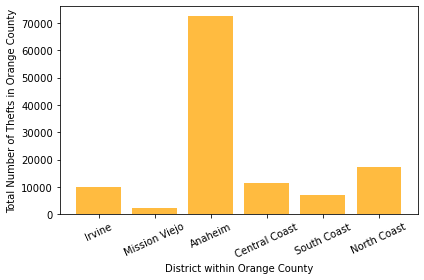

In [18]:
# Names of the regions within Orange County
oc_region = ["Irvine", "Mission Viejo", "Anaheim", "Central Coast", "South Coast", "North Coast"]

# 
x_axis = np.arange(len(oc_region))
tick_locations = [value + 0.4 for value in x_axis]
plt.bar(x_axis, new_consolidated_theft_df["Total Thefts"], color='orange', alpha=0.75, align="edge")
plt.xticks(tick_locations, oc_region, rotation = 25)
plt.xlabel("District within Orange County")
plt.ylabel("Total Number of Thefts in Orange County")
plt.tight_layout()
plt.savefig("Output/CrimeRate_Theft_Luan.png")
plt.show()

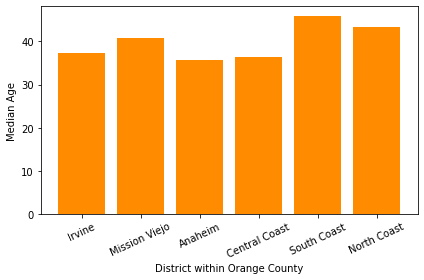

In [21]:
x_axis = np.arange(len(oc_region))
tick_locations = [value + 0.4 for value in x_axis]
plt.bar(x_axis, new_consolidated_theft_df["Median Age"], color='darkorange', align="edge")
plt.xticks(tick_locations, oc_region, rotation = 25)
plt.xlabel("District within Orange County")
plt.ylabel("Median Age")
plt.tight_layout()
plt.savefig("Output/CrimeRate_Age_Luan.png")
plt.show()

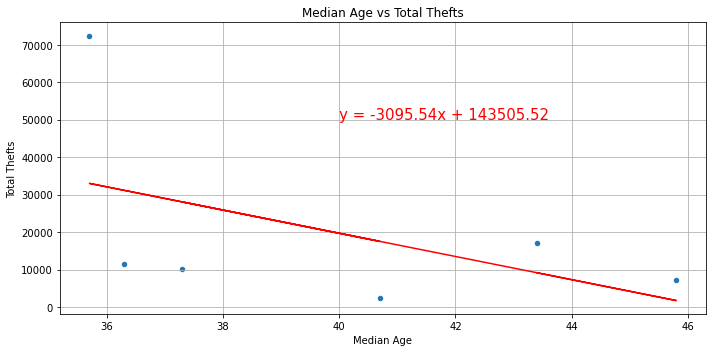

The correlation between median age and theft counts is -0.49.


In [30]:
# Comparing Median Age against theft crimes in Orange County
new_consolidated_theft_df.plot(kind = "scatter", x = "Median Age", y = "Total Thefts", grid = True, figsize = (10, 5), title = "Median Age vs Total Thefts")

# Calculating linear regression line to see level of correlation
x_values = new_consolidated_theft_df["Median Age"]
y_values = new_consolidated_theft_df["Total Thefts"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq,(40, 50000), fontsize=15,color="red")
plt.tight_layout()
plt.savefig("Output/AgeVCrime__Luan.png")
plt.show()
print(f"The correlation between median age and theft counts is {rvalue:,.2f}.")

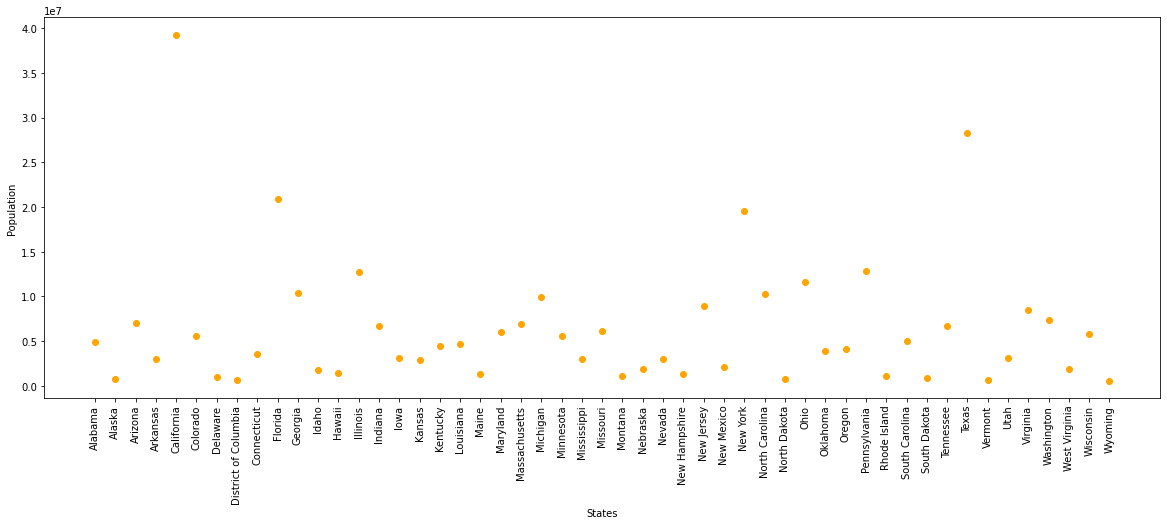

In [25]:
# Looking at the Population across each state
plt.figure(figsize=(20, 7))
x_axis = np.arange(len(censuscrimedata))
tick_locations = [value for value in x_axis]
plt.scatter(x_axis, censuscrimedata["Population"], color='orange')
plt.xticks(tick_locations, censuscrimedata["State Name"], rotation = "vertical")
plt.xlabel("States")
plt.ylabel("Population")
#plt.savefig("")
plt.show()

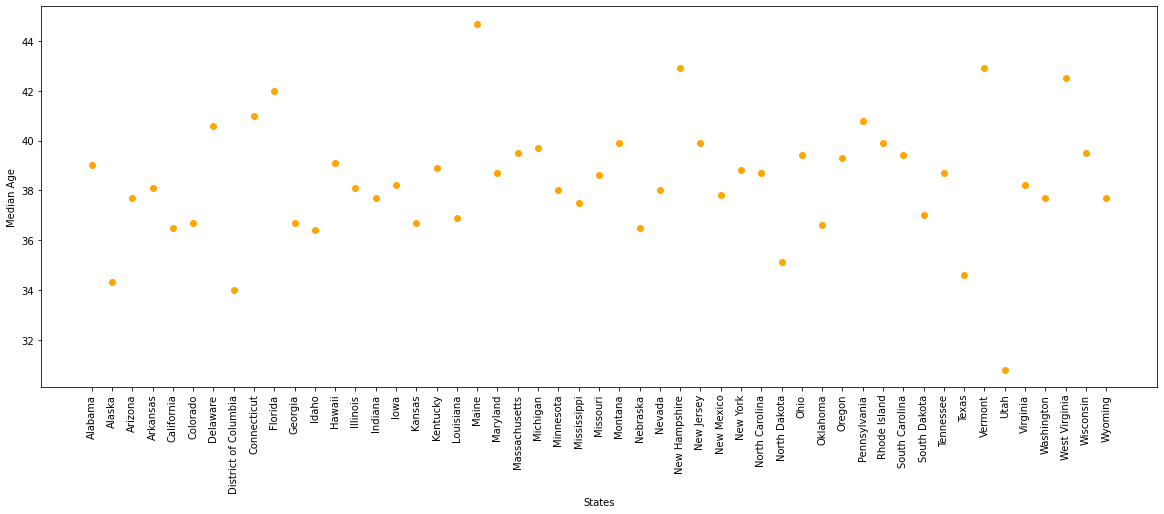

In [26]:
# Looking at the Median Age across each state
plt.figure(figsize=(20, 7))
x_axis = np.arange(len(censuscrimedata))
tick_locations = [value for value in x_axis]
plt.scatter(x_axis, censuscrimedata["Median Age"], color='orange')
plt.xticks(tick_locations, censuscrimedata["State Name"], rotation = "vertical")
plt.xlabel("States")
plt.ylabel("Median Age")
#plt.savefig("")
plt.show()

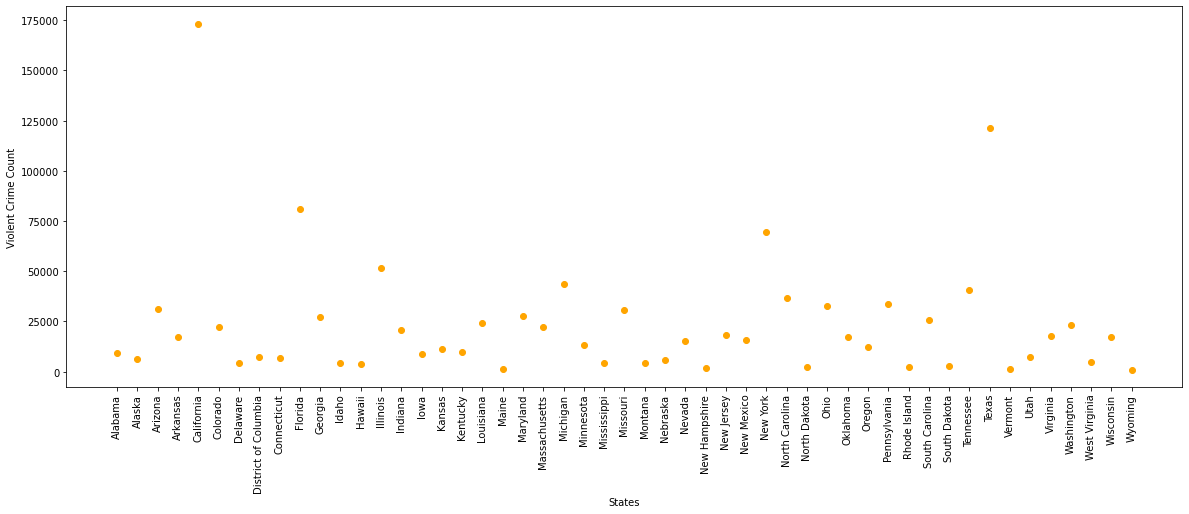

In [27]:
# Looking at the Violent Crime across each state
plt.figure(figsize=(20, 7))
x_axis = np.arange(len(censuscrimedata))
tick_locations = [value for value in x_axis]
plt.scatter(x_axis, censuscrimedata["Violent Crime Count"], color='orange')
plt.xticks(tick_locations, censuscrimedata["State Name"], rotation = "vertical")
plt.xlabel("States")
plt.ylabel("Violent Crime Count")
#plt.savefig("")
plt.show()

<Figure size 1440x504 with 0 Axes>

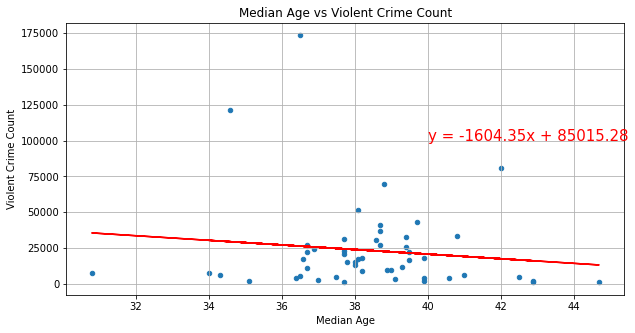

The correlation between median age and theft counts is -0.13.


In [28]:
# Median Age vs Violent Crime Data
age_v_crime = censuscrimedata.groupby("Median Age")["Violent Crime Count"]

censuscrimedata_copy = censuscrimedata.set_index("Median Age")

plt.figure(figsize=(20, 7))
censuscrimedata.plot(kind = "scatter", x = "Median Age", y = "Violent Crime Count", grid = True, figsize = (10, 5), title = "Median Age vs Violent Crime Count")

x_values = censuscrimedata["Median Age"]
y_values = censuscrimedata["Violent Crime Count"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq,(40, 100000),fontsize=15,color="red")

plt.show()

print(f"The correlation between median age and theft counts is {rvalue:,.2f}.")